In [29]:
from cobra.postgres.interface import PgInterface
import geopandas as gpd

In [2]:
country = 'swiss'

In [3]:
i = PgInterface()

In [10]:
# create table with routeable powerlines
sql = f"CREATE TABLE {country}power.powerroute AS SELECT (row_number() over())::int id, ST_length(way) as cost, way as the_geom FROM {country}power.planet_osm_line WHERE power = 'line'"
i.__execute_sql__(sql)

In [11]:
# add columns
for col in ['source','target']:
    sql = f"ALTER TABLE {country}power.powerroute ADD COLUMN {col} bigint;"
    i.__execute_sql__(sql)

In [12]:
# create topology
i.__execute_sql__(f"SELECT pgr_createTopology('{country}power.powerroute', 2);")

In [18]:
# persist connected components table
sql = f"CREATE TABLE {country}power.connected_components AS SELECT * FROM pgr_connectedComponents('SELECT id, source, target, cost, cost AS reverse_cost FROM {country}power.powerroute')"
i.__execute_sql__(sql)

In [35]:
# Get branch based on a single segment
segment_id = '3135'
get_comonent_id = f"SELECT cc.component FROM {country}power.powerroute pr INNER JOIN {country}power.powerroute_vertices_pgr v ON ST_DWithin(v.the_geom, pr.the_geom, 0.1) INNER JOIN {country}power.connected_components cc ON cc.node = v.id WHERE pr.id = {segment_id} LIMIT 1"
res = i.__execute_sql__(get_comonent_id, fetch='one')
comp_id = str(res[0])
get_geom = f"SELECT pr.the_geom as geom FROM {country}power.connected_components cc INNER JOIN {country}power.powerroute_vertices_pgr v ON cc.node = v.id INNER JOIN {country}power.powerroute pr ON ST_DWithin(v.the_geom, pr.the_geom, 0.1) WHERE cc.COMPONENT = {comp_id}"

conn = i.get_connection()
branch = gpd.GeoDataFrame.from_postgis(get_geom, conn)



<AxesSubplot:>

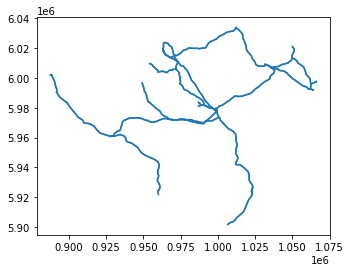

In [36]:
branch.plot()